### Explaining Least angle regression 

Least angle regression (LAR) is an algorithm for fitting linear regression models to high-dimensional data, where the number of predictors is much larger than the number of observations.

The basic idea of LAR is to start with an intercept-only model and then add predictors one by one in a way that minimizes the residual sum of squares (RSS). However, unlike forward selection, which chooses the predictor with the highest correlation with the current residual at each step, LAR increases the coefficients of all the predictors that are equally correlated with the residual in a direction that is equiangular to their correlations. This means that the coefficients grow at the same rate until another predictor becomes as correlated with the residual as the current set of predictors.

LAR produces a sequence of models with different numbers of predictors, and each model can be represented by a value of the L1 norm of the coefficient vector. The LAR algorithm can efficiently compute this sequence and provide a piecewise linear solution path that can be used for cross-validation or other model selection criteria.

Some advantages of LAR are:

It is computationally fast and can handle high-dimensional data.
It produces a stable and intuitive solution that behaves as expected when two or more predictors are highly correlated.
It can be easily modified to produce other methods such as lasso and forward stagewise regression.
Some disadvantages of LAR are:

It may not select the true causal predictors when there is noise in the response and multicollinearity among the predictors.
It may not perform well when there are outliers or non-normal errors in the data.
It assumes a linear relationship between the response and the predictors.

### Explianing Orthogonal matching pursuit

Orthogonal matching pursuit (OMP) is a greedy algorithm for finding a sparse solution to a linear system of equations Ax = b, where A is a matrix with more columns than rows and x is a vector with only a few non-zero elements.

The basic idea of OMP is to start with an empty set of selected columns of A and a zero vector x. At each iteration, OMP chooses the column of A that has the highest correlation with the current residual (the difference between b and Ax), adds it to the selected set, and updates x by projecting b onto the span of the selected columns using the least squares method. This process is repeated until a stopping criterion is met, such as reaching a desired number of non-zero elements in x or achieving a sufficiently small residual.

Some advantages of OMP are:

It is simple to implement and understand.
It can recover the exact sparse solution under some conditions on the mutual coherence of A and the sparsity of x.
It can handle noisy measurements by using an error tolerance as a stopping criterion12.
Some disadvantages of OMP are:

It may not converge to the optimal sparse solution if the columns of A are not sufficiently incoherent or if x is not sufficiently sparse.
It may be sensitive to outliers or non-normal errors in the data.
It may be computationally expensive if A is very large or dense.

### Libraries



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from skimage.metrics import peak_signal_noise_ratio

### Loading Original Image

In [ ]:
# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
image = plt.imread("mandrill.jpg")
image = np.mean(image, axis=2)
image = image  / 255.0

# downsample for higher speed
image = (
    image[::4, ::4]
    + image[1::4, ::4]
    + image[::4, 1::4]
    + image[1::4, 1::4]
)
image /= 4.0
height, width = image.shape

### Generate Noisy Image

In [ ]:
distorted = image.copy()
distorted[:, :] += 0.075 * np.random.randn(height, width)

### Display Noisy Image

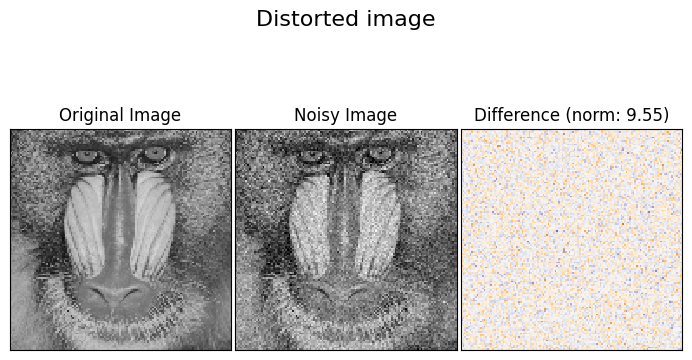

In [ ]:
"""display denoising"""
plt.figure(figsize=(7, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
plt.xticks(())
plt.yticks(())
plt.subplot(1, 3, 2)
plt.title("Noisy Image")
plt.imshow(distorted, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
plt.xticks(())
plt.yticks(())
plt.subplot(1, 3, 3)
difference = distorted - image
plt.title("Difference (norm: %.2f)" % np.sqrt(np.sum(difference**2)))
plt.imshow(
difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation="nearest"
)
plt.xticks(())
plt.yticks(())
plt.suptitle("Distorted image", size=16)
plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)


### Extract Patches From Original Image

In [ ]:
print("Extracting reference patches...")
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted")

Extracting reference patches...
14884 patches extracted


###Learn the dictionary

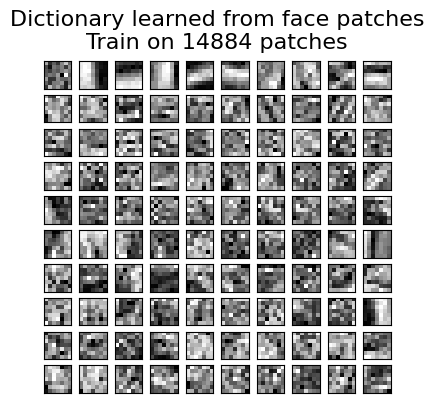

In [ ]:
dico = MiniBatchDictionaryLearning(
    n_components=300,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
)
V = dico.fit(data).components_

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train on %d patches" % ( len(data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

### Extract noisy patches

In [ ]:
data = extract_patches_2d(distorted[:, :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept

 ### Reconstruction

In [ ]:
def show_images(image,distorted,reconstruction,title):
      plt.figure(figsize=(10, 4))
      plt.subplot(1, 4, 1)
      plt.title("Original Image")
      plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
      plt.xticks(())
      plt.yticks(())
      plt.subplot(1, 4, 2)
      plt.title("Noisy Image")
      plt.imshow(distorted, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
      plt.xticks(())
      plt.yticks(())
      plt.subplot(1, 3, 3)
      plt.subplot(1, 4, 3)
      plt.title("Reconstructed Image")
      psnr = peak_signal_noise_ratio(image, reconstruction)
      plt.title("PSNR: %.2f" % psnr)
      plt.imshow(reconstruction, vmin=0, vmax=1, cmap=plt.cm.gray, interpolation="nearest")
      plt.xticks(())
      plt.yticks(())
      plt.subplot(1, 4, 4)
      difference = reconstruction - image
      plt.title("Difference (norm: %.2f)" % np.sqrt(np.sum(difference**2)))
      plt.imshow(
      difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr, interpolation="nearest"
      )
      plt.xticks(())
      plt.yticks(())
      plt.suptitle(title, size=16)
      plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

done in 2.39s.


<ipython-input-17-07927c595a05>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 3)


done in 7.68s.


<ipython-input-17-07927c595a05>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 3)


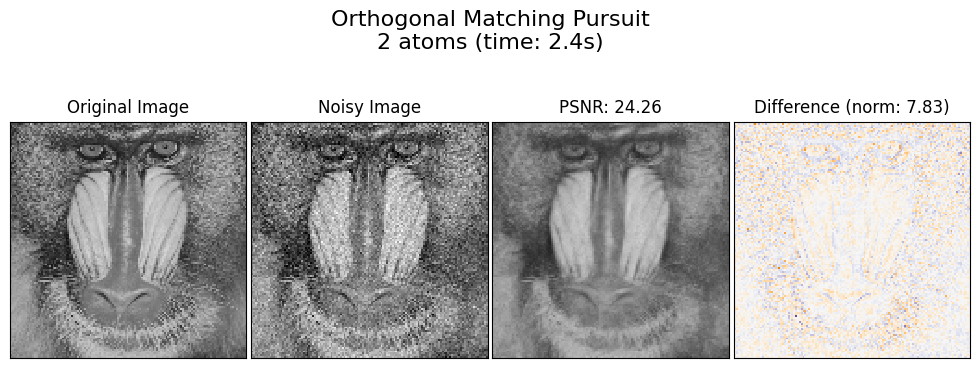

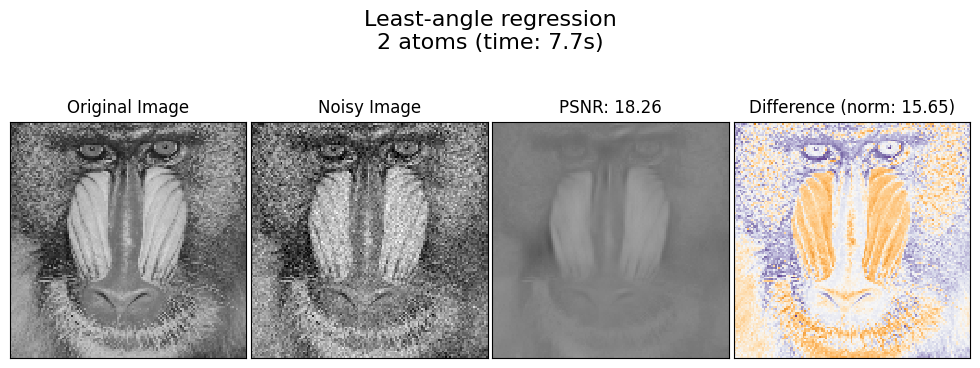

In [ ]:
transform_algorithms = [
    ("Orthogonal Matching Pursuit\n2 atoms", "omp", {"transform_n_nonzero_coefs": 2}),
    ("Least-angle regression\n2 atoms", "lars", {"transform_n_nonzero_coefs": 2})
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:

    reconstructions[title] = image.copy()
    t0 = time()
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    reconstructions[title][:,  :] = reconstruct_from_patches_2d(
        patches, (height, width)
    )
    dt = time() - t0
    print("done in %.2fs." % dt)
    show_images(image,distorted,reconstructions[title], title + " (time: %.1fs)" % dt)

plt.show()

As you can see Orthogonal matching pursuit have better PSNR and also it is faster. Visually, LAR has blurred the image too much.